In [72]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from mejores_modelos.funciones_aux import imprimir_resultados, guardar_resultado_en_csv
from tensorboard.plugins.hparams import api as hp

Aqui utilizamos el archivo train_limpio.csv que es el train.csv pero filtrado sacando reseñas que no estaban en español

In [19]:
RUTA_TRAIN, RUTA_TEST = "train.csv", "test.csv"

In [20]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Aqui ya observamos que el dataset no contiene nulos

<Axes: xlabel='sentimiento', ylabel='count'>

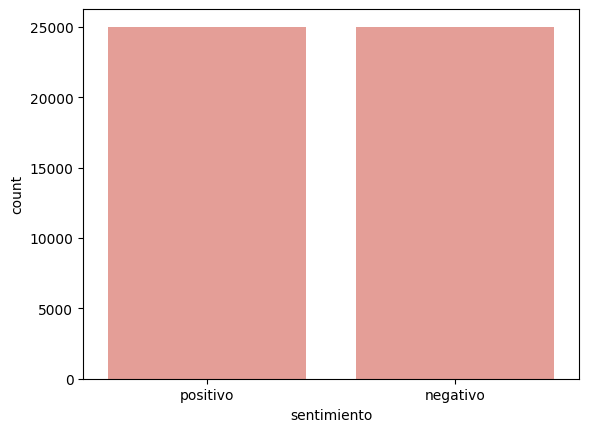

In [22]:
sns.countplot(x=df_train["sentimiento"], color="#F1948A")

In [23]:
df_train["sentimiento"].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

In [24]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [25]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [26]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)

In [27]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [28]:
x_test = df_test["review_es"]

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

## Bernoulli Naive Bayes

In [31]:
def busqueda_hiperparametros_nb(modelo, x_vectorizado):
  param_grid = {
    "alpha": [0.6, 0.65, 0.7, 0.8],
    "fit_prior": [False, True],
    "class_prior": [[0.2, 0.6], [0.1, 0.5], [0.2, 0.7]]
  }
  
  grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=10, scoring="f1_macro")
  
  grid_search.fit(x_vectorizado, y_train)

  return grid_search

In [32]:
nb_classifier = BernoulliNB()
gs = busqueda_hiperparametros_nb(nb_classifier, x_train_vec)

In [33]:
print(gs.best_params_)

{'alpha': 0.8, 'class_prior': [0.1, 0.5], 'fit_prior': False}


In [34]:
best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], fit_prior=gs.best_params_["fit_prior"])

gs.fit(x_train_vec, y_train)
y_pred_nb = gs.predict(x_test_vec)

F1: 0.8498920086393088
Precision: 0.8648351648351649
Recall: 0.8354564755838642
Accuracy: 0.8517333333333333


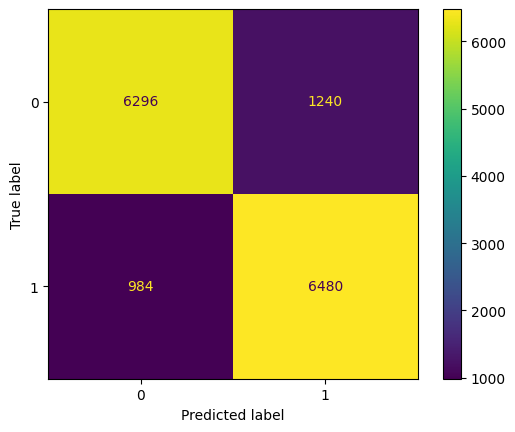

In [35]:
imprimir_resultados(y_test_, y_pred_nb)

In [36]:
y_pred_nb_ = gs.predict(vectorizer.transform(x_test))

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [38]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [39]:
n_iter = 5

param_distributions = { 
    "criterion" : ["gini", "entropy", "log_loss"],
    "min_samples_leaf" : [1, 5, 10],
    "min_samples_split" : [2, 4, 10, 12, 16],
    "n_estimators": [10, 20, 50, 70, 100],
    "max_depth": range(15, 50) }


cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = RandomForestClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [40]:
best_rf = randomcv.best_estimator_

In [41]:
best_params_rf = randomcv.best_params_

In [42]:
best_rf = RandomForestClassifier(
            criterion=best_params_rf["criterion"],
            min_samples_leaf=best_params_rf["min_samples_leaf"],
            min_samples_split=best_params_rf["min_samples_split"],
            n_estimators=best_params_rf["n_estimators"],
            max_depth=best_params_rf["max_depth"])

In [43]:
best_rf.fit(x_train_vec, y_train)

y_pred_rf = best_rf.predict(x_test_vec)

F1: 0.8371430509394289
Precision: 0.8562508672124324
Recall: 0.8188694267515924
Accuracy: 0.8399333333333333


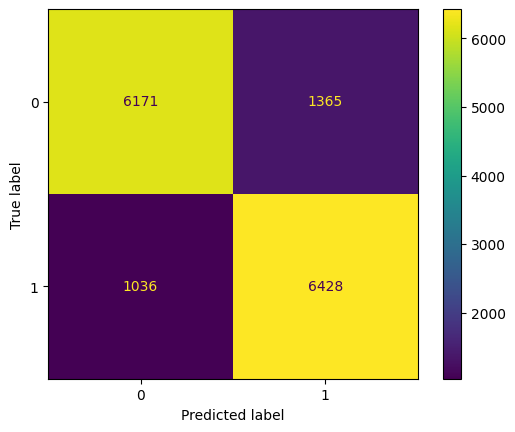

In [44]:
imprimir_resultados(y_test_, y_pred_rf)

In [65]:
y_pred_rf_ = best_rf.predict(vectorizer.transform(x_test))

## XGBoost

In [45]:
from xgboost import XGBClassifier

In [46]:
n_iter = 5

param_distributions = { 
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4],
    "max_depth": [3, 4, 5, 7],
    "n_estimators": [100, 200, 300] 
    }

cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = XGBClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [47]:
best_params_xgboost = randomcv.best_params_

In [48]:
best_xgboost = XGBClassifier(learning_rate=best_params_xgboost["learning_rate"],
                        n_estimators=best_params_xgboost["n_estimators"],
                        max_depth=best_params_xgboost["max_depth"])

In [49]:
best_xgboost.fit(x_train_vec, y_train)

y_pred_xgboost = best_xgboost.predict(x_test_vec)

F1: 0.8631466238372482
Precision: 0.8706628864587552
Recall: 0.8557590233545648
Accuracy: 0.8636666666666667


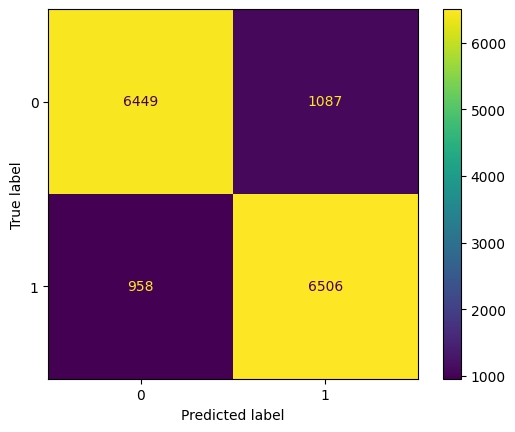

In [50]:
imprimir_resultados(y_test_, y_pred_xgboost)

In [66]:
y_pred_xgboost_ = best_xgboost.predict(vectorizer.transform(x_test))

## Red neuronal

In [51]:
max_words = 5000
max_len = 100

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.text import Tokenizer

In [53]:
total_reviews = df_train["review_es"].astype(str)
total_labels = df_train["sentimiento"].values

In [54]:
tokenizer_obj = Tokenizer(num_words = max_words)
tokenizer_obj.fit_on_texts(total_reviews)

In [55]:
X_data_tokens = tokenizer_obj.texts_to_sequences(total_reviews)

In [56]:
X_data_count = tokenizer_obj.sequences_to_matrix(X_data_tokens, mode = "count")

In [57]:
Y_data = df_train.sentimiento

In [58]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_data_count, Y_data, test_size = 0.3, random_state = 123)

In [59]:
HP_INPUT_WIDTH = hp.HParam("input_width", hp.Discrete([12, 24, 48]))
HP_OUTPUT_WIDTH = hp.HParam("output_width", hp.Discrete([6, 12, 24]))  # No usaremos esto
HP_RNN_UNITS = hp.HParam("rnn_units", hp.Discrete([30, 40, 60]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.05, 0.1, 0.2]))
HP_OPTIMIZER = hp.HParam("optimizer", hp.Discrete(["adam"]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([0.001]))

METRIC_ACCURACY = "accuracy"

In [60]:
def train_test_model(hparams):
    model = Sequential([
        Dense(hparams[HP_INPUT_WIDTH], activation='relu', input_shape=(max_words,)),
        Dropout(hparams[HP_DROPOUT]),
        Dense(hparams[HP_RNN_UNITS], activation='relu'),
        Dropout(hparams[HP_DROPOUT]),
        Dense(1, activation='sigmoid')  # Solo una unidad de salida para clasificación binaria
    ])
    
    optimizer = hparams[HP_OPTIMIZER]
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[METRIC_ACCURACY])
    
    model.fit(X_train_count, y_train_count, epochs=5, batch_size=32, validation_split=0.2)
    
    _, accuracy = model.evaluate(X_test_count, y_test_count)
    return accuracy

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # log the hyperparameters
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        return accuracy

# Diccionario para guardar los mejores hiperparámetros
best_hparams = None
best_accuracy = 0.0

session_num = 0

for input_width in HP_INPUT_WIDTH.domain.values:
    for output_width in HP_OUTPUT_WIDTH.domain.values:
        for rnn_units in HP_RNN_UNITS.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for optimizer in HP_OPTIMIZER.domain.values:
                    for learning_rate in HP_LEARNING_RATE.domain.values:
                        hparams = {
                            HP_INPUT_WIDTH: input_width,
                            HP_OUTPUT_WIDTH: output_width,
                            HP_RNN_UNITS: rnn_units,
                            HP_DROPOUT: dropout,
                            HP_OPTIMIZER: optimizer,
                            HP_LEARNING_RATE: learning_rate,
                        }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h: hparams[h] for h in hparams})
                        accuracy = run('logs/hparam_tuning/' + run_name, hparams)
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_hparams = hparams
                        session_num += 1

print(f'Best hyperparameters: {best_hparams}')
print(f'Best accuracy: {best_accuracy}')

--- Starting trial: run-0
{HParam(name='input_width', domain=Discrete([12, 24, 48]), display_name=None, description=None): 12, HParam(name='output_width', domain=Discrete([6, 12, 24]), display_name=None, description=None): 6, HParam(name='rnn_units', domain=Discrete([30, 40, 60]), display_name=None, description=None): 30, HParam(name='dropout', domain=Discrete([0.05, 0.1, 0.2]), display_name=None, description=None): 0.05, HParam(name='optimizer', domain=Discrete(['adam']), display_name=None, description=None): 'adam', HParam(name='learning_rate', domain=Discrete([0.001]), display_name=None, description=None): 0.001}


/home/taiel/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7769 - loss: 0.4688 - val_accuracy: 0.8473 - val_loss: 0.3538
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8991 - loss: 0.2557 - val_accuracy: 0.8679 - val_loss: 0.3248
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9230 - loss: 0.1992 - val_accuracy: 0.8629 - val_loss: 0.3442
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9455 - loss: 0.1499 - val_accuracy: 0.8591 - val_loss: 0.3770
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9619 - loss: 0.1093 - val_accuracy: 0.8501 - val_loss: 0.4367
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.8561 - loss: 0.4358
--- Starting trial: run-1
{HParam(name='input_width', domain=Discrete([12, 24, 48]), display_name=None, description=None): 12, HParam(name='output_width', domain=Discrete([6, 12, 24]), display_name=None, description=None): 6, HParam(name='rnn_units', domain=Discrete([30, 40, 60]), displa

In [61]:
# Entrenar un nuevo modelo con los mejores hiperparámetros
mejor_red = Sequential([
    Dense(best_hparams[HP_INPUT_WIDTH], activation='relu', input_shape=(max_words,)),
    Dropout(best_hparams[HP_DROPOUT]),
    Dense(best_hparams[HP_RNN_UNITS], activation='relu'),
    Dropout(best_hparams[HP_DROPOUT]),
    Dense(1, activation='sigmoid')
])

optimizer = best_hparams[HP_OPTIMIZER]
if optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_hparams[HP_LEARNING_RATE])

mejor_red.compile(optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=[METRIC_ACCURACY])

mejor_red.fit(X_train_count, y_train_count, epochs=5, batch_size=32, validation_split=0.2)

# Evaluar el mejor modelo
loss, accuracy = mejor_red.evaluate(X_test_count, y_test_count)
print(f'Final model loss: {loss}, accuracy: {accuracy}')


/home/taiel/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7727 - loss: 0.4757 - val_accuracy: 0.8674 - val_loss: 0.3154
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9021 - loss: 0.2473 - val_accuracy: 0.8647 - val_loss: 0.3185
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9191 - loss: 0.1973 - val_accuracy: 0.8570 - val_loss: 0.3724
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9457 - loss: 0.1498 - val_accuracy: 0.8551 - val_loss: 0.4129
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9585 - loss: 0.1136 - val_accuracy: 0.8454 - val_loss: 0.4201
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.8540 - loss: 0.4201
Final model loss: 0.41495269536972046, accuracy: 0.8560666441917419


In [62]:
X_train_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_train_count = tokenizer_obj.sequences_to_matrix(X_train_tokens, mode = "count")
y_pred_red_ = mejor_red.predict(X_test_count)
y_pred_red_ = np.round(y_pred_red_)

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


F1: 0.8571995502348039
Precision: 0.8470588235294118
Recall: 0.8675860222251974
Accuracy: 0.8560666666666666


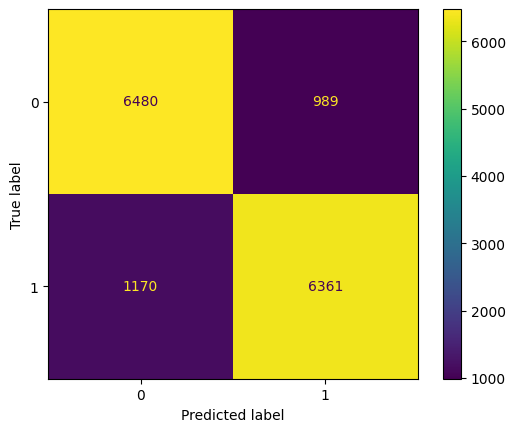

In [63]:
imprimir_resultados(y_test_count, y_pred_red_)

## Ensamble

In [67]:
from collections import Counter

In [68]:
def ensamble_votacion(array1, array2, array3):
    combined = np.vstack((array1, array2, array3)).T
    
    resultado = np.apply_along_axis(lambda row: Counter(row).most_common(1)[0][0], axis=1, arr=combined)
    
    return resultado

F1: 0.8638909508063972
Precision: 0.8788960593162158
Recall: 0.8493895966029724
Accuracy: 0.8655333333333334


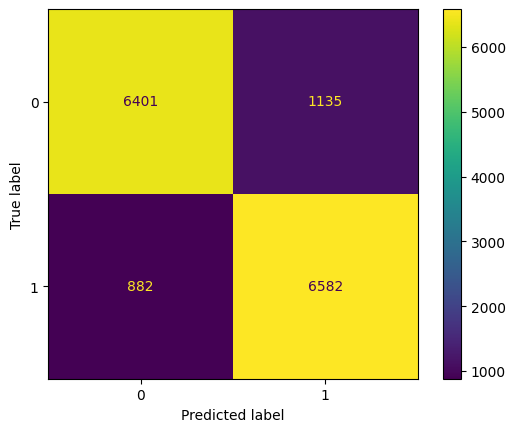

In [70]:
imprimir_resultados(y_test_, ensamble_votacion(y_pred_nb, y_pred_rf, y_pred_xgboost))

In [74]:
guardar_resultado_en_csv(ensamble_votacion(y_pred_nb_, y_pred_rf_, y_pred_xgboost_), df_test, "ensamble.csv")